In [692]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os 
import sklearn
from data_preperation import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [658]:
data_original = pd.read_csv('ElectionsData.csv', header=0)
data_original.head()


,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Last_school_grades,Most_Important_Issue,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Financial_agenda_matters,Num_of_kids_born_last_10_years,Overall_happiness_score
0,Violets,1.0,113.445801,1688.510190,Below_30,1477.809692,Yes,202.042787,Yes,Male,...,60.0,Financial,12.0,683.760440,1.0,Public_or_other,Industry_or_other,No,1.0,392.803101
1,Browns,2.0,161.720841,696.069582,Below_30,2969.865888,Yes,88.942300,Yes,Male,...,60.0,Financial,9.0,793.017823,2.0,Car,Industry_or_other,No,0.0,41.028616
2,Greens,6.0,524.947117,50048.853880,30-45,30803.812970,No,789.796962,Yes,Female,...,80.0,Healthcare,10.0,253.102383,1.0,Motorcycle_or_truck,Services_or_Retail,No,0.0,635.000942
3,Whites,1.0,521.454363,50265.185360,Below_30,30396.557250,No,565.727946,Yes,Male,...,NaN,Social,8.0,278.904297,1.0,Car,Services_or_Retail,No,0.0,502.278182
4,Browns,6.0,210.879361,7793.195795,30-45,5021.415879,No,423.589896,Yes,Female,...,70.0,Social,11.0,605.564038,4.0,Car,Public_Sector,No,2.0,40.469037


In [659]:
discrete_features = ['Occupation_Satisfaction', 'Last_school_grades', 'Number_of_differnt_parties_voted_for', 'Number_of_valued_Kneset_members', 'Num_of_kids_born_last_10_years']
continuous_features = ['Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
                      'Financial_balance_score_(0-1)', '%Of_Household_Income', 'Yearly_IncomeK', 'Avg_size_per_room', 'Garden_sqr_meter_per_person_in_residancy_area', 'Avg_Residancy_Altitude',
                      'Yearly_ExpensesK', '%Time_invested_in_work', 'Avg_education_importance', 'Avg_Satisfaction_with_previous_vote', 
                      'Avg_monthly_household_cost', 'Phone_minutes_10_years', 'Avg_government_satisfaction', 'Weighted_education_rank', '%_satisfaction_financial_policy',
                      'Avg_monthly_income_all_years', 'Political_interest_Total_Score', 'Overall_happiness_score']
nominal_features = ['Will_vote_only_large_party', 'Age_group']
onehot_nominal_features = ['Most_Important_Issue', 'Main_transportation', 'Occupation']
binary_features = ['Gender', 'Looking_at_poles_results', 'Married', 'Financial_agenda_matters', 'Voting_Time']

numerical_features = discrete_features + continuous_features
total_nominal_features = nominal_features + onehot_nominal_features + binary_features

In [660]:
uniform_features = ['Occupation_Satisfaction', 'Financial_balance_score_(0-1)',
                    '%Of_Household_Income', 'Yearly_IncomeK', 'Avg_government_satisfaction',
                    '%_satisfaction_financial_policy', 'Garden_sqr_meter_per_person_in_residancy_area',
                    'Yearly_ExpensesK', '%Time_invested_in_work']
normal_features = ['Number_of_differnt_parties_voted_for', 'Number_of_valued_Kneset_members',
                   'Avg_environmental_importance',
                   'Avg_education_importance', 'Avg_monthly_household_cost', 'Weighted_education_rank',
                   'Overall_happiness_score', 'Avg_size_per_room', 'Avg_Residancy_Altitude']
unknown_features = ['Last_school_grades', 'Num_of_kids_born_last_10_years',
                    'Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses',
                    'Avg_monthly_expense_on_pets_or_plants', 'Avg_Satisfaction_with_previous_vote',
                    'Phone_minutes_10_years', 'Avg_monthly_income_all_years', 'Political_interest_Total_Score']

features_with_negative = {'Avg_monthly_expense_when_under_age_21': 147, 'Avg_lottary_expanses': 152 ,
                          'Avg_monthly_income_all_years': 152}

Questions:
1. unknown featuers - to which distribution they belong
- which scaling/noramalization should we use on them
2. How to check dependencies between feature before and after scaling
3. When should we use one hot transformation
4. Should we remove negative or change to positive
5. Should we use closeset fit to imputate
6. What algos we need to use to feature select (*which ones exict in sklearn)


In [679]:
data = data_original.copy()
data[nominal_features].head()

,Will_vote_only_large_party,Age_group
0,Yes,Below_30
1,Maybe,Below_30
2,Yes,30-45
3,No,Below_30
4,No,30-45


In [690]:
data.loc[data['Main_transportation'].isnull(), :]

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Last_school_grades,Most_Important_Issue,Number_of_differnt_parties_voted_for,Political_interest_Total_Score,Number_of_valued_Kneset_members,Main_transportation,Occupation,Financial_agenda_matters,Num_of_kids_born_last_10_years,Overall_happiness_score
356,Violets,9.0,258.001810,35852.05931,Below_30,7492.104346,No,411.327170,Yes,Male,...,60.0,Financial,9.0,342.472684,4.0,NaN,Services_or_Retail,Yes,2.0,419.459210
456,Browns,1.0,178.109523,21820.27061,30-45,3594.147877,No,555.408361,Yes,Female,...,80.0,Healthcare,13.0,NaN,1.0,NaN,Public_Sector,No,0.0,266.244012
458,Turquoises,9.0,662.885216,81801.08396,Below_30,49055.051620,No,633.478325,Yes,Female,...,90.0,Environment,13.0,164.244869,0.0,NaN,Hightech,No,3.0,454.594232
694,Browns,4.0,494.171578,60314.15232,45_and_up,27308.673680,Yes,548.197275,Yes,Female,...,80.0,Healthcare,10.0,330.491644,2.0,NaN,Public_Sector,Yes,0.0,200.929385
849,Purples,5.0,551.049225,61062.37382,30-45,33933.155120,Yes,327.521971,Yes,Female,...,90.0,Environment,14.0,428.252114,1.0,NaN,Public_Sector,Yes,0.0,313.329023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9551,Turquoises,1.0,935.388463,165623.64030,30-45,97538.638080,Yes,600.065061,No,Female,...,90.0,Environment,14.0,157.347354,1.0,NaN,Hightech,No,1.0,463.694635
9619,Browns,10.0,331.382766,109651.52470,30-45,12322.076220,Yes,1463.533453,No,Male,...,80.0,Healthcare,13.0,834.818209,1.0,NaN,Industry_or_other,Yes,0.0,983.562789
9760,Purples,8.0,365.388590,113342.22600,45_and_up,14966.109730,Yes,1441.441138,No,Female,...,80.0,Healthcare,12.0,788.933473,1.0,NaN,Hightech,Yes,0.0,981.556411
9772,Turquoises,3.0,266.009667,32586.18314,Below_30,7961.019094,No,654.452095,Yes,Male,...,100.0,Education,12.0,178.974020,2.0,NaN,Services_or_Retail,Yes,0.0,539.785767


In [691]:

data = convert_to_onehot(data, onehot_nominal_features)
data

Vote                                              Violets
Occupation_Satisfaction                                 9
Avg_monthly_expense_when_under_age_21             258.002
Avg_lottary_expanses                              35852.1
Age_group                                        Below_30
Avg_monthly_expense_on_pets_or_plants              7492.1
Looking_at_poles_results                               No
Avg_environmental_importance                      411.327
Married                                               Yes
Gender                                               Male
Voting_Time                                      By_16:00
Financial_balance_score_(0-1)                    0.826927
%Of_Household_Income                              0.55809
Yearly_IncomeK                                       9330
Avg_size_per_room                                 177.677
Garden_sqr_meter_per_person_in_residancy_area     35.1859
Avg_Residancy_Altitude                            4524.17
Yearly_Expense

In [668]:
data = convert_to_categorical(data)
data[nominal_features].head()

,Will_vote_only_large_party,Age_group
0,2,2
1,0,2
2,2,0
3,1,2
4,1,0


In [670]:
# Looks like the negative data is simillar to the distributaion of the data so maybe we need to negate it 
# instead of removing it
for feature in features_with_negative.keys():
    data.loc[data[feature] < 0,feature] = data.loc[data[feature] < 0,feature].abs()
print(f'Number of negative values: {(data.dropna().values < 0).sum()}')

#data.loc[:, features_with_negative.keys()][data.loc[:, features_with_negative.keys()] < 0].hist(figsize=(16,16))
# Notice - this does not change the corr between the features

Number of negative values: 0


In [632]:
# TODO check if this is needed - non of them is showing in the features selected (But they might change the other which were chosen)
# change binary features to -1 1 instead of 0 1
data = change_binary_values(data, binary_features)
# Change nominal feature to -1 0 1 instead of 0 1 2
data.loc[data['Will_vote_only_large_party'] == 1, 'Will_vote_only_large_party'] = -1
data.loc[data['Will_vote_only_large_party'] == 2, 'Will_vote_only_large_party'] = 1
data.loc[data['Age_group'] == 2, 'Age_group'] = -1


In [648]:
# Split
train_indices, val_indices, test_indices = split_data(data, test_size=0.15, val_size=0.15)
X_train = data.iloc[train_indices, 1:]
y_train = data.iloc[train_indices, 0]
X_val = data.iloc[val_indices, 1:]
y_val = data.iloc[val_indices, 0]
X_test = data.iloc[test_indices, 1:]
y_test = data.iloc[test_indices, 0]

In [672]:
XY_train = insert_label_to_data(X_train, y_train)


print(f'Number of negative values: {(XY_train.dropna().values < 0).sum()}')
#XY_train = remove_negative(XY_train) # TODO check if removing is good or maybe abs
print(f'Number of negative values: {(XY_train.dropna().values < 0).sum()}')

print(f'Number of nan before: {XY_train.isnull().values.sum()}')
outlier = Outlier(XY_train, numeric_feat)
XY_train = outlier.remove_outlier(XY_train, 4.5)
print(f'Number of nan after: {XY_train.isnull().values.sum()}')


SyntaxError: invalid syntax (<ipython-input-672-020bbc55cf14>, line 8)

In [650]:

print(f'Number of nan before: {XY_train.isnull().values.sum()}')
imputation = Imputation(XY_train)
XY_train = imputation.impute_train(XY_train)
print(f'Number of nan after: {XY_train.isnull().values.sum()}')        


Number of nan before: 4045
Number of nan after: 0


In [593]:
print(f'Number of nan before: {X_test.isnull().values.sum() + X_val.isnull().values.sum()}')
X_test, X_val = imputation.impute_test_val(X_test, X_val)
print(f'Number of nan after: {X_test.isnull().values.sum() + X_val.isnull().values.sum()}')  

Number of nan before: 1690
Number of nan after: 0


C:\Users\aviv_\Miniconda3\envs\cs236756\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


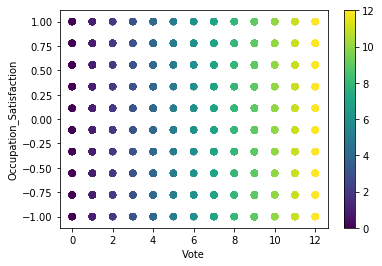

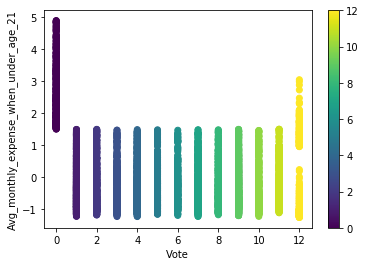

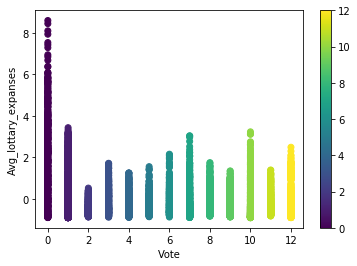

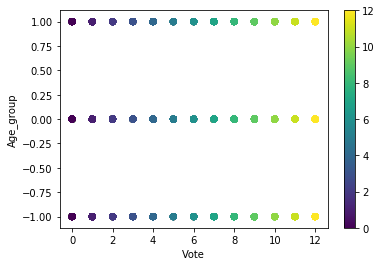

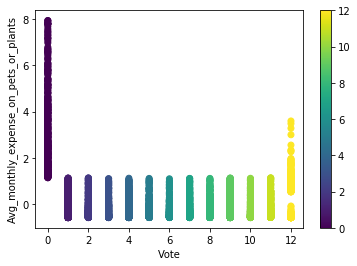

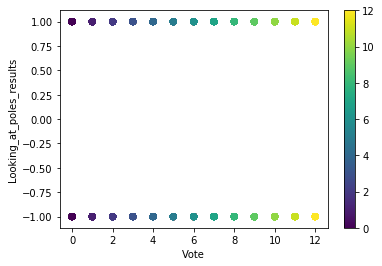

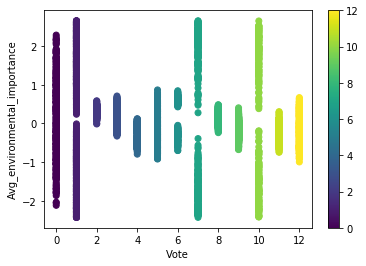

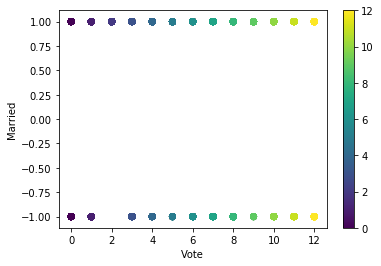

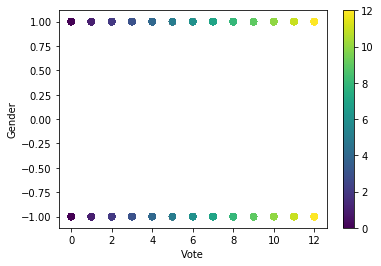

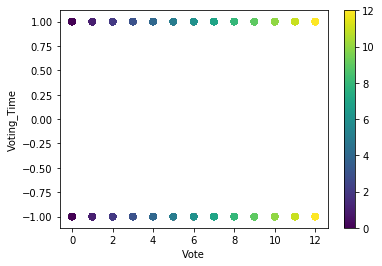

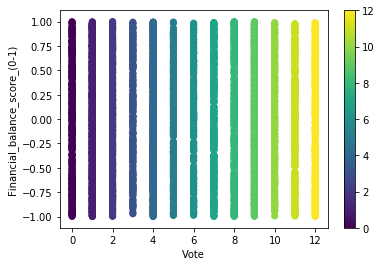

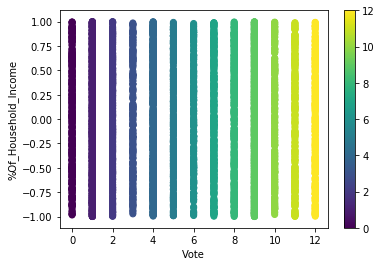

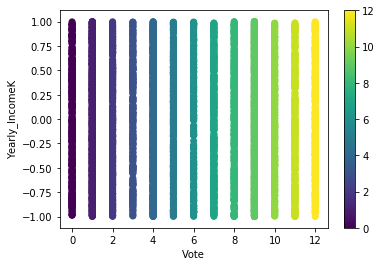

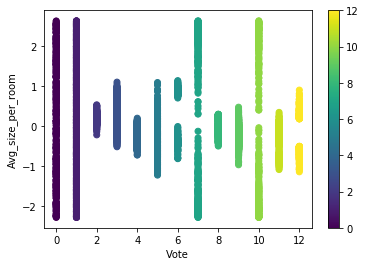

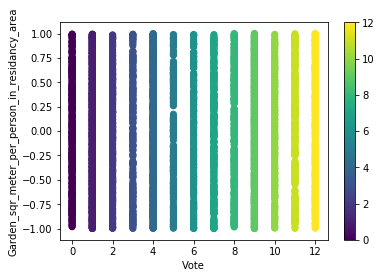

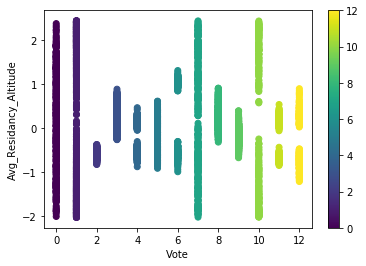

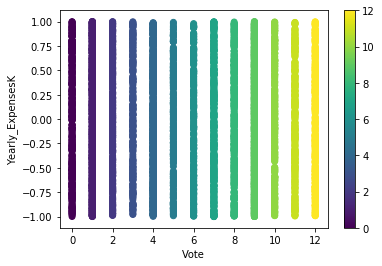

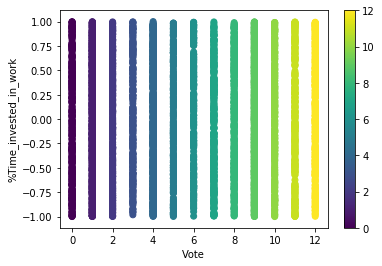

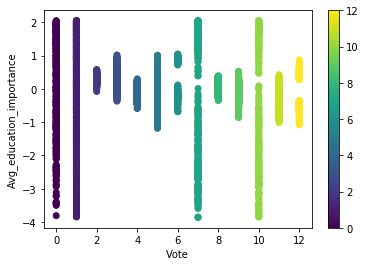

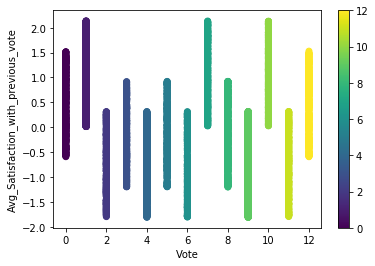

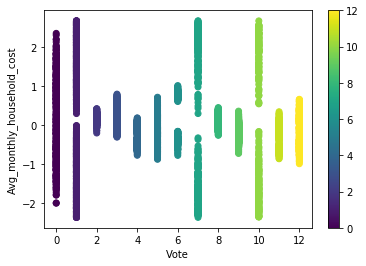

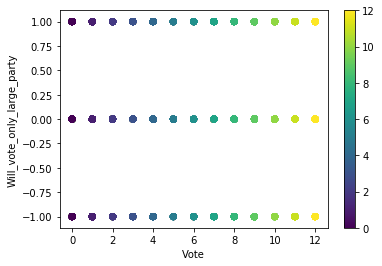

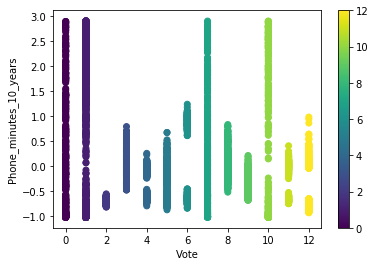

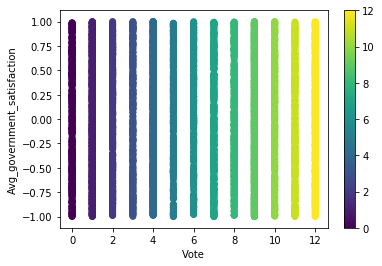

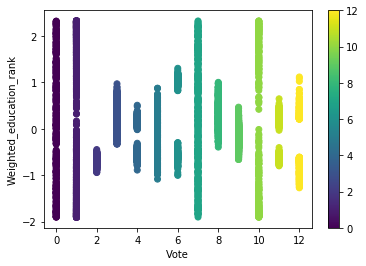

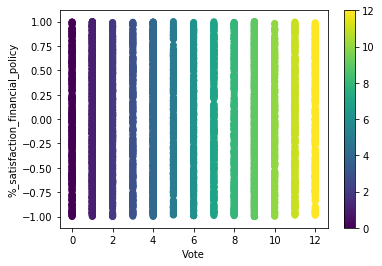

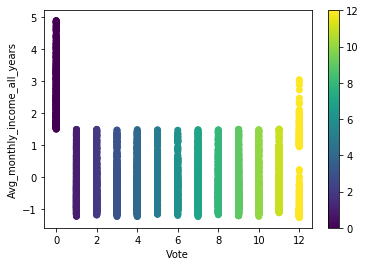

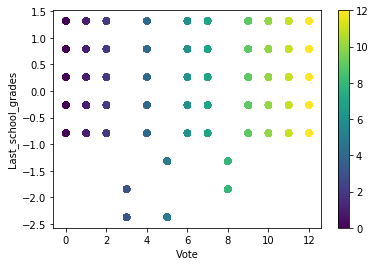

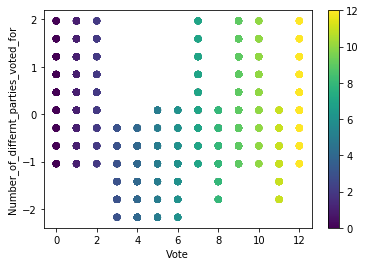

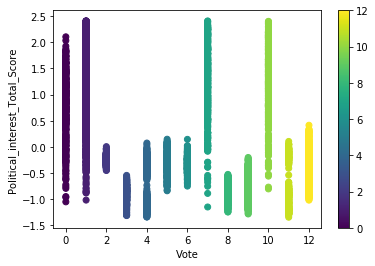

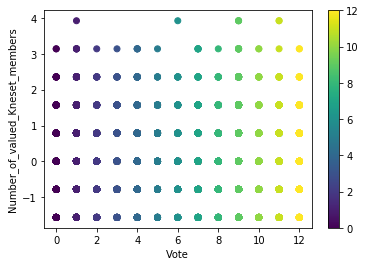

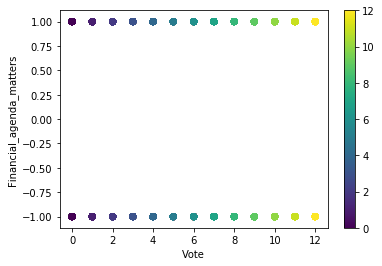

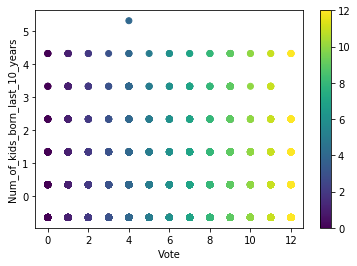

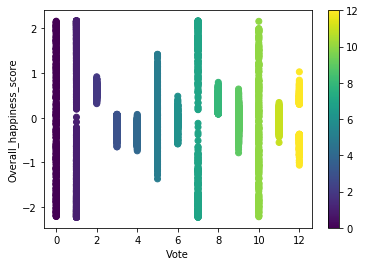

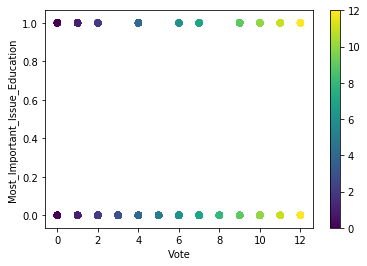

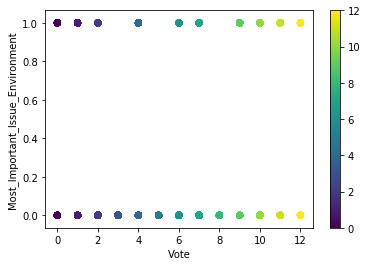

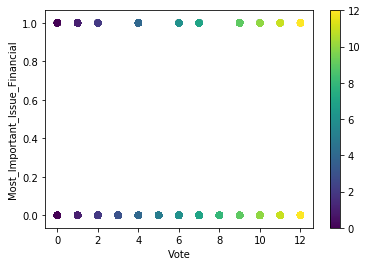

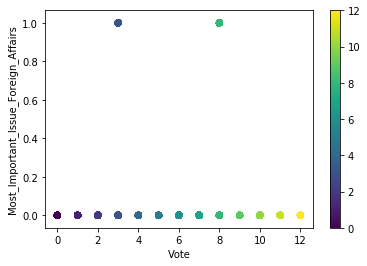

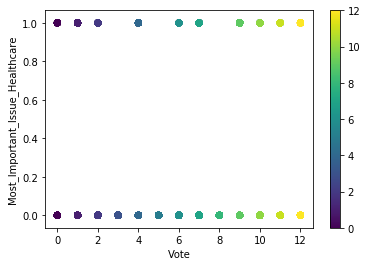

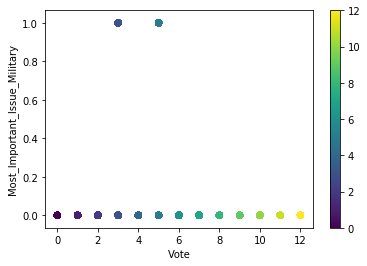

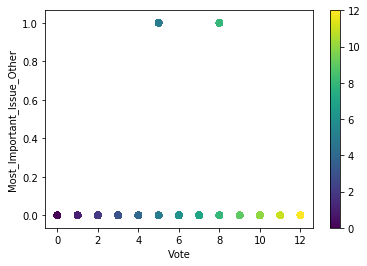

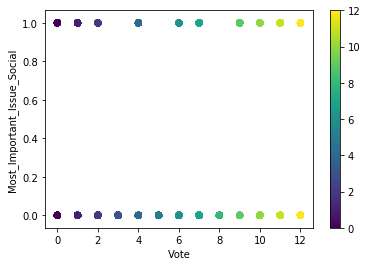

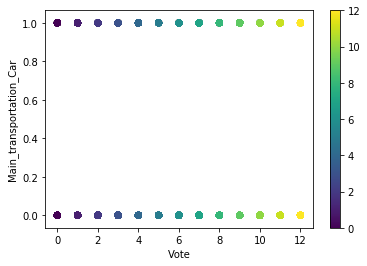

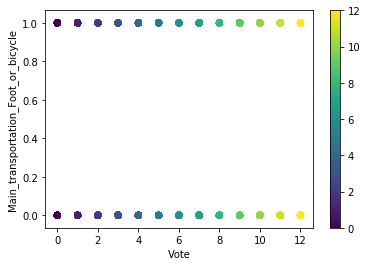

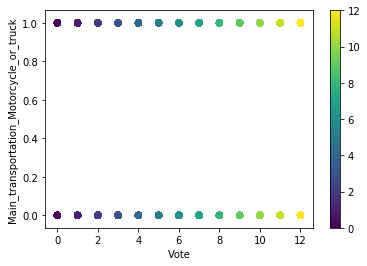

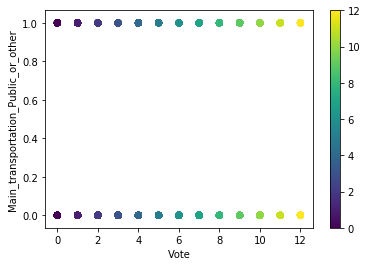

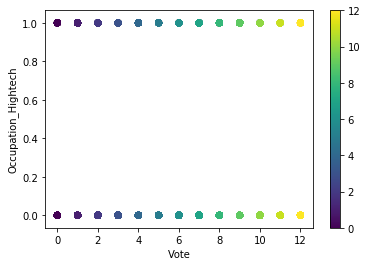

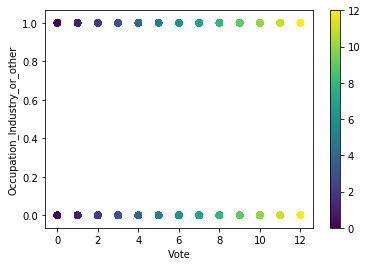

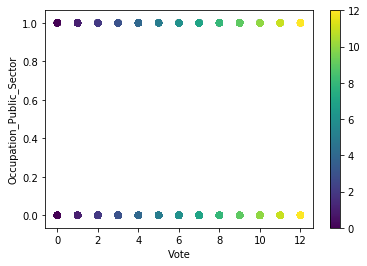

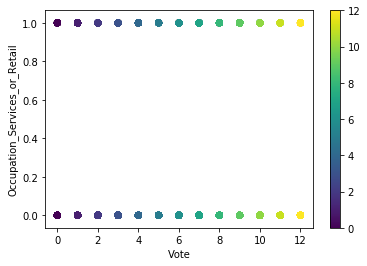

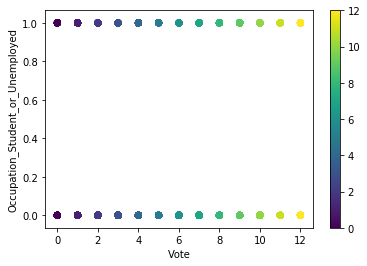

In [624]:
for f1 in ['Vote']:
    for f2 in XY_train.columns:
        if f1 != f2:
            df = XY_train.loc[:, [f1, f2]]
            plt.figure()
            plt.scatter(x=df[f1], y=df[f2], c=df['Vote'])
            
            plt.xlabel(f1)
            plt.ylabel(f2)
            plt.colorbar()
            

C:\Users\aviv_\Miniconda3\envs\cs236756\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


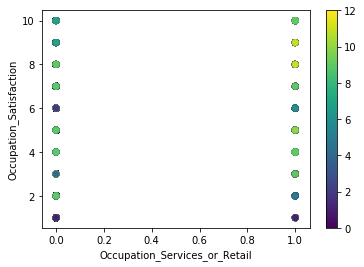

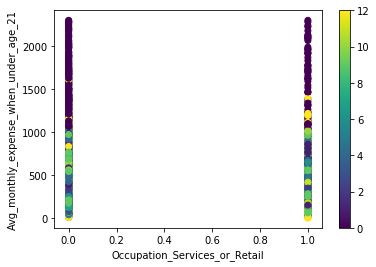

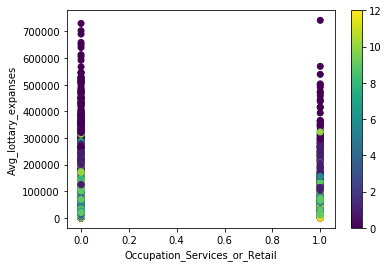

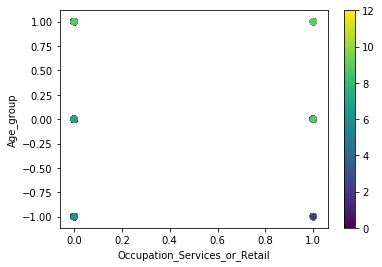

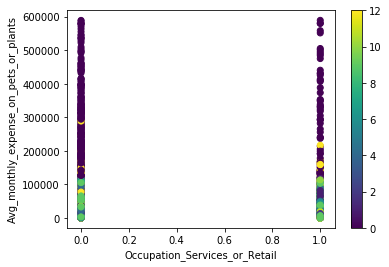

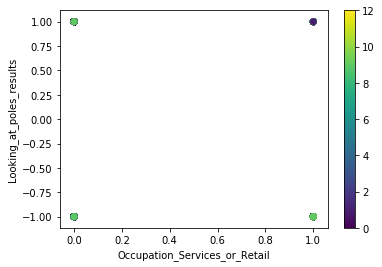

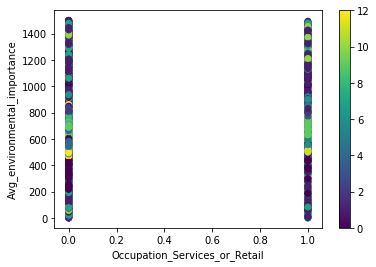

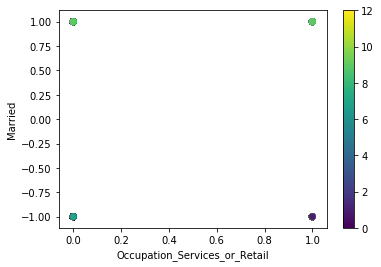

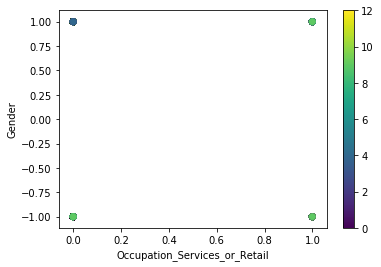

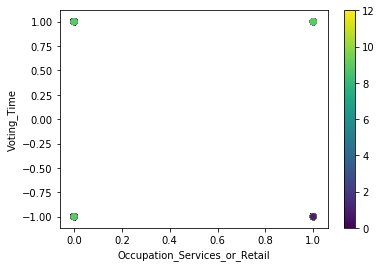

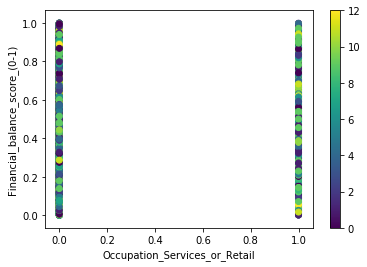

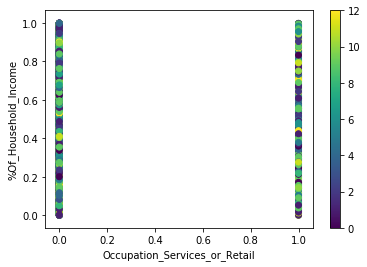

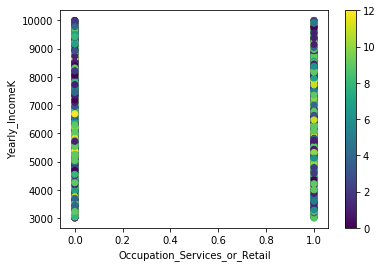

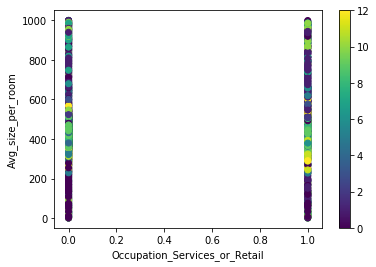

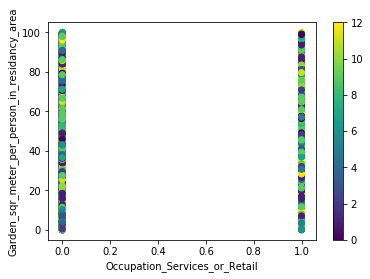

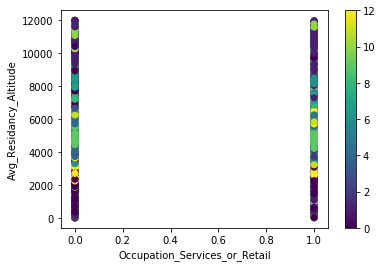

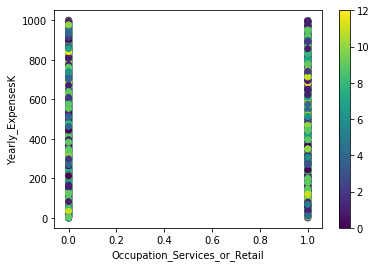

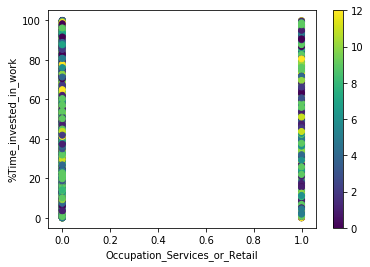

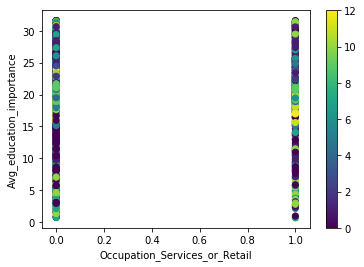

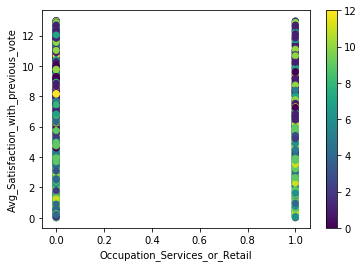

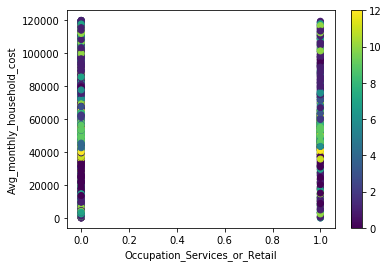

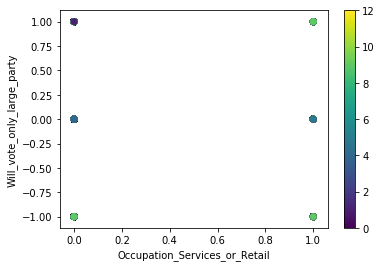

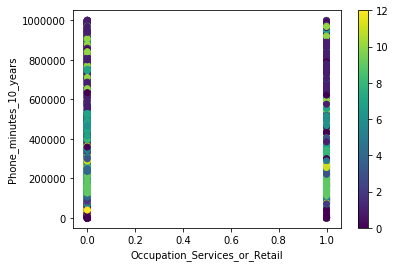

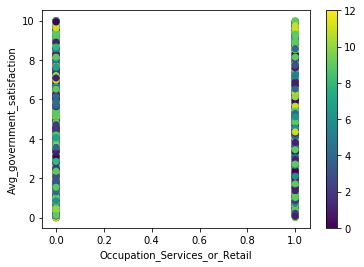

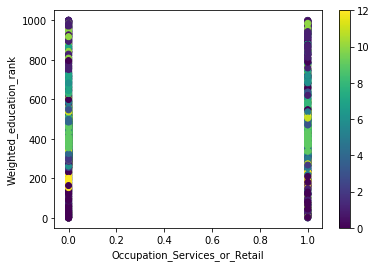

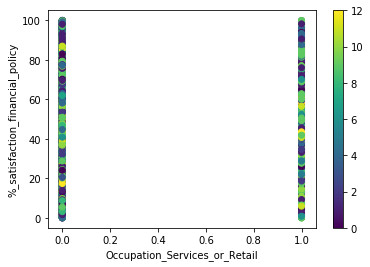

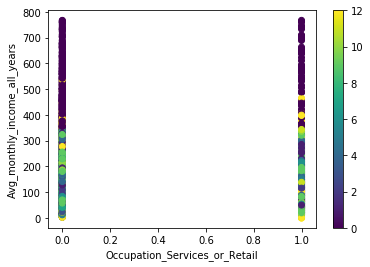

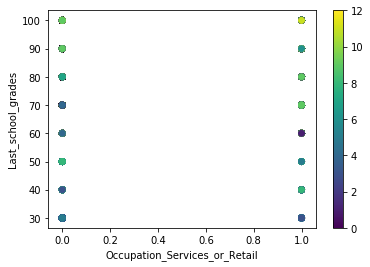

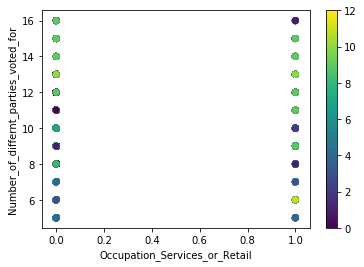

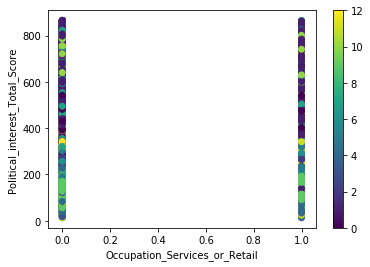

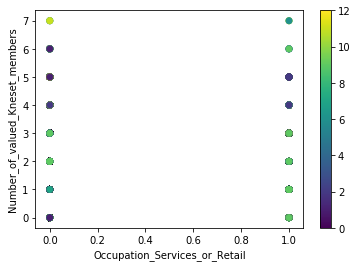

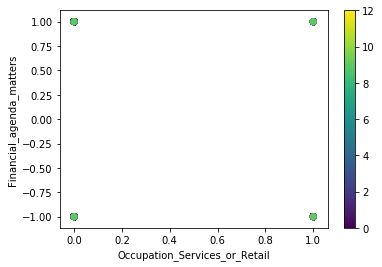

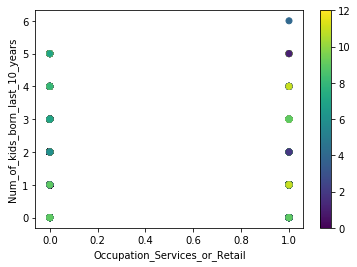

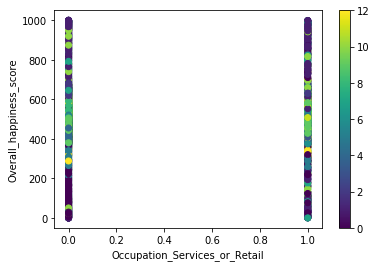

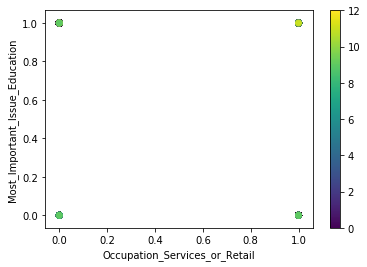

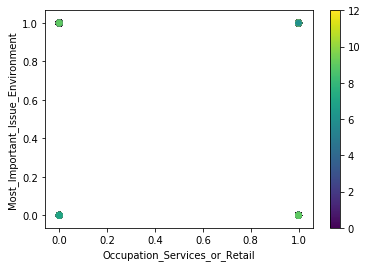

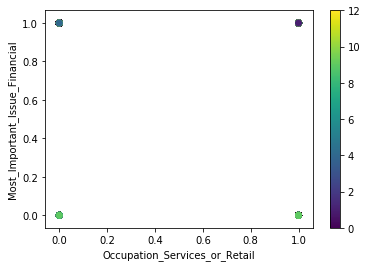

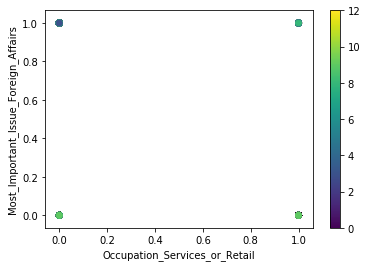

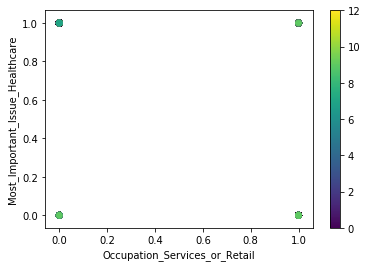

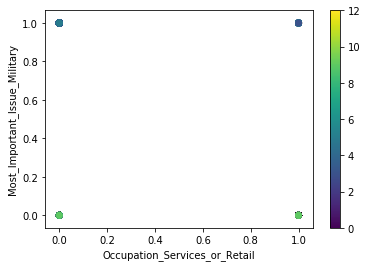

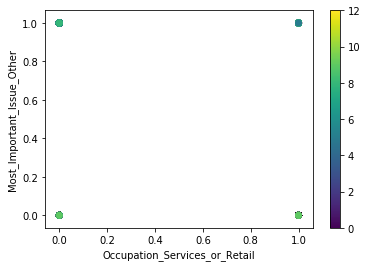

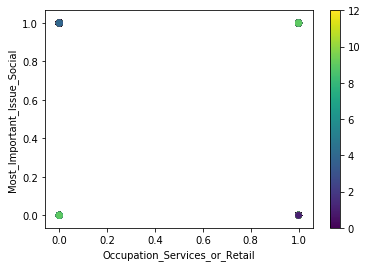

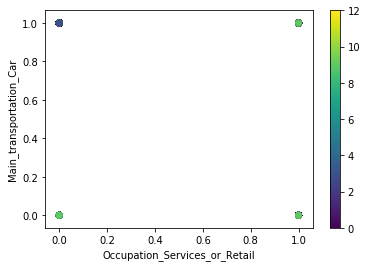

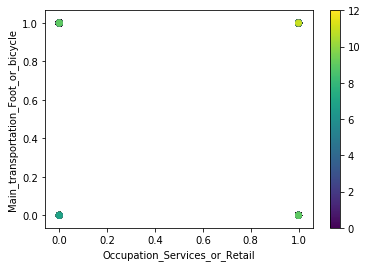

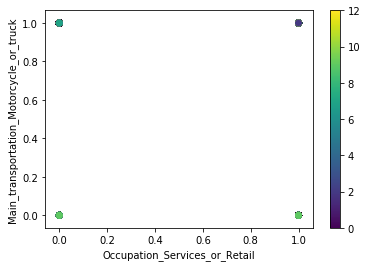

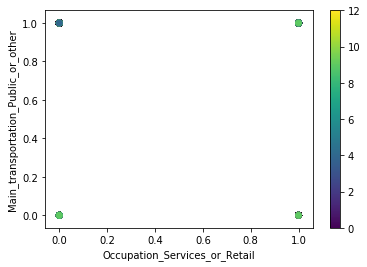

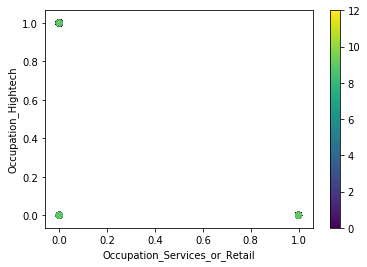

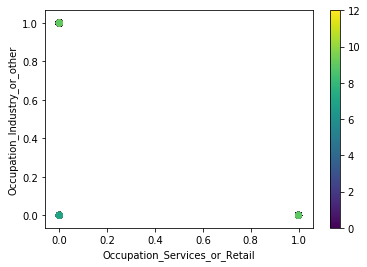

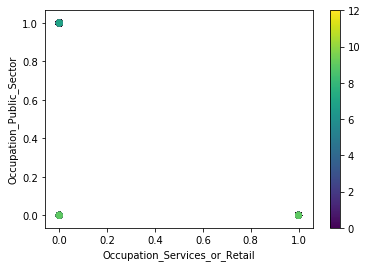

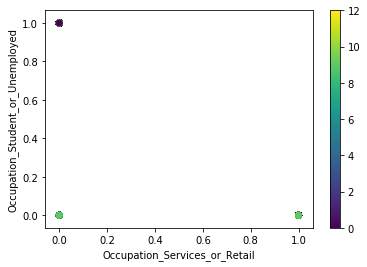

In [594]:
i = 0
for f1 in ['Occupation_Services_or_Retail']:
    if f1 == 'Vote':
        continue
    else:
        for f2 in XY_train.columns:
            if i > 100:
                break
            if f2 != 'Vote' and f1 != f2:
                df = XY_train.loc[:, ['Vote', f1, f2]]
                plt.figure()
                plt.scatter(x=df[f1], y=df[f2], c=df['Vote'])
                
                plt.xlabel(f1)
                plt.ylabel(f2)
                plt.colorbar()
                i +=1

In [595]:
scaler = Scaling(XY_train)
XY_train = scaler.scale_min_max(XY_train, uniform_features, -1, 1) 
XY_train = scaler.normalization(XY_train, normal_features + unknown_features) 
X_val = scaler.scale_min_max(X_val, uniform_features, -1, 1) 
X_val = scaler.normalization(X_val, normal_features + unknown_features) 
X_test = scaler.scale_min_max(X_test, uniform_features, -1, 1) 
X_test = scaler.normalization(X_test, normal_features + unknown_features) 

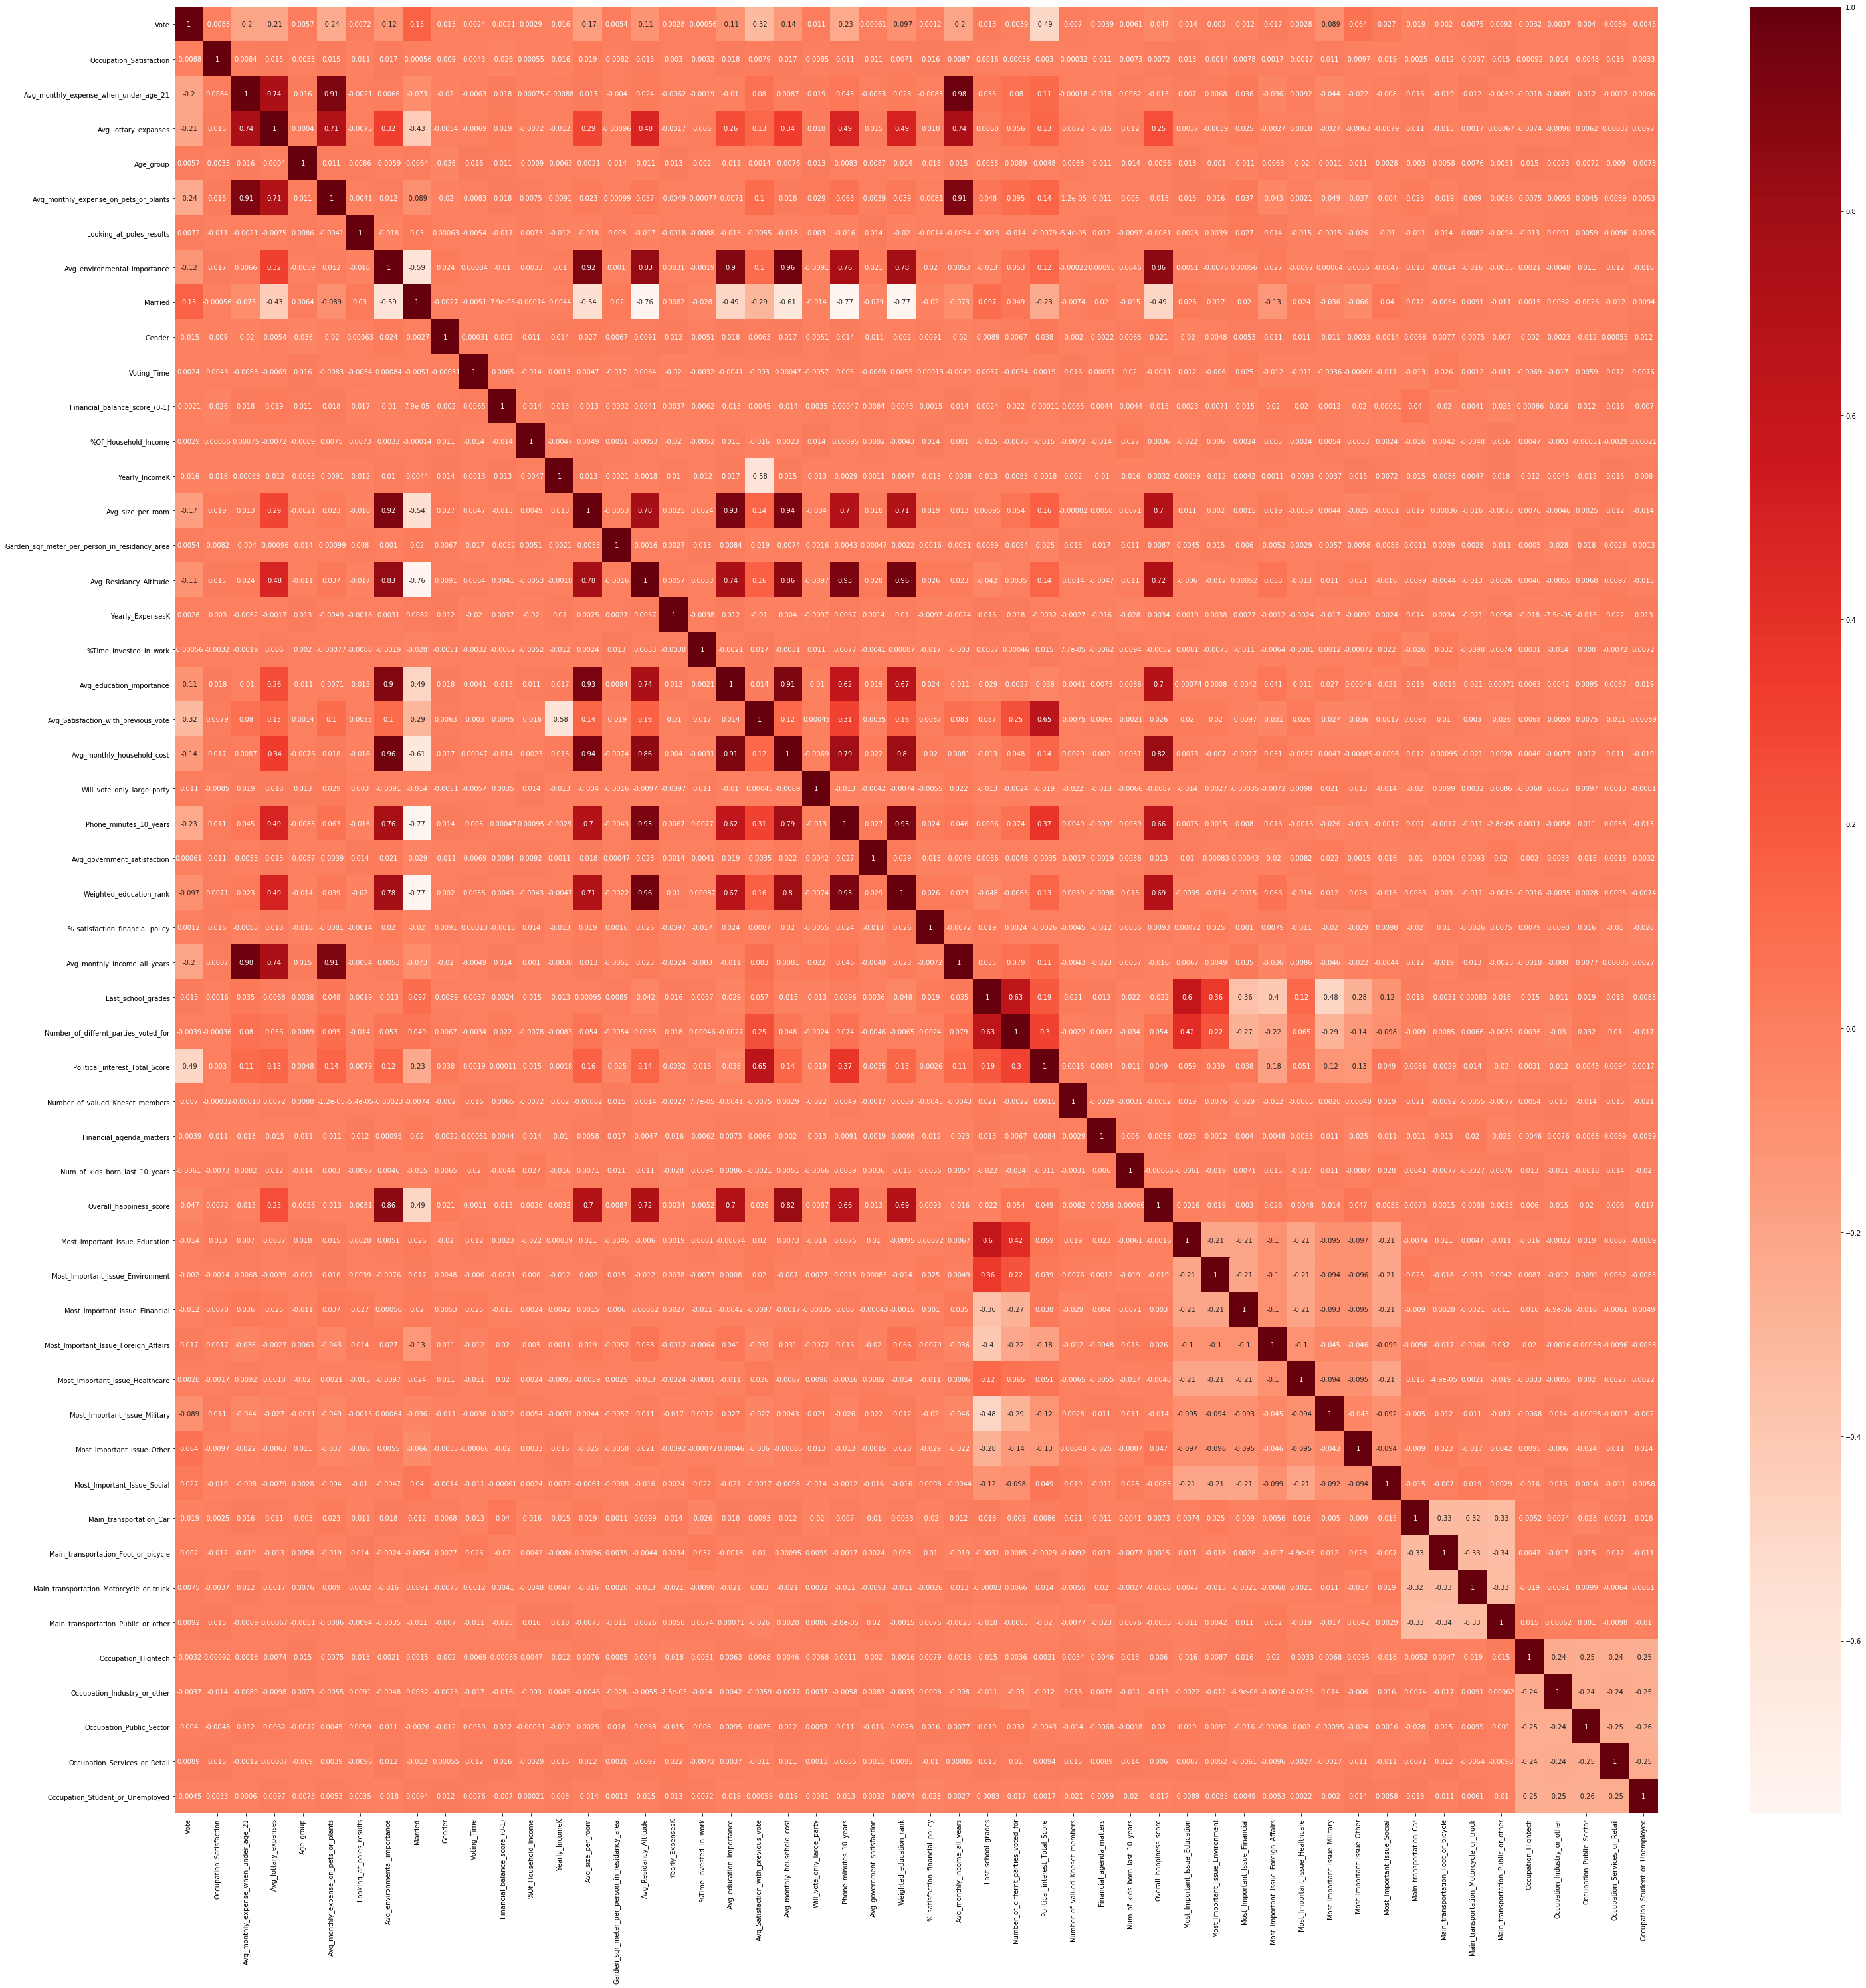

In [580]:
#to_remove  = ['Avg_monthly_expense_on_pets_or_plants', 'Avg_monthly_income_all_years', 'Avg_size_per_room', 'Avg_monthly_household_cost', 'Avg_education_importance',
#             'Phone_minutes_10_years', 'Weighted_education_rank']
#XY_train = XY_train.drop(columns=to_remove)
#print(XY_train.columns.values)

# using pearson correlation to find correlation between all features (this finds only linear relations)
import seaborn as sns
plt.figure(figsize=(50, 50))
cor = XY_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


In [ ]:
cor = cor[abs(cor)>0.2]
cor.to_csv('correlation_matrix.csv')

In [700]:
########################## DONE PREPROSSING - START FEATURE SELECTION ##############################
XY_train = pd.read_csv('train_transformed.csv', index_col=0, header=0)
XY_val = pd.read_csv('val_transformed.csv', index_col=0, header=0)
XY_test = pd.read_csv('test_transformed.csv', index_col=0, header=0)
X_train, y_train = split_label_from_data(XY_train)
X_val, y_val = split_label_from_data(XY_val)

from test import test_accuracy
from feature_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from relief import *
XY_train

,Vote,Occupation_Satisfaction,Avg_monthly_expense_when_under_age_21,Avg_lottary_expanses,Age_group,Avg_monthly_expense_on_pets_or_plants,Looking_at_poles_results,Avg_environmental_importance,Married,Gender,...,Most_Important_Issue_Social,Main_transportation_Car,Main_transportation_Foot_or_bicycle,Main_transportation_Motorcycle_or_truck,Main_transportation_Public_or_other,Occupation_Hightech,Occupation_Industry_or_other,Occupation_Public_Sector,Occupation_Services_or_Retail,Occupation_Student_or_Unemployed
0,10,-1.000000,-0.963730,-0.869742,-1,-0.573573,1,-1.683494,1,1,...,0,0,0,0,1,0,1,0,0,0
1,1,-0.777778,-0.834949,-0.882489,-1,-0.551758,1,-2.070697,1,1,...,0,1,0,0,0,0,1,0,0,0
2,2,0.111111,0.134007,-0.248593,0,-0.144799,-1,0.328702,1,-1,...,0,0,0,1,0,0,0,0,1,0
3,11,-1.000000,0.124689,-0.245815,-1,-0.150754,-1,-0.438406,1,1,...,1,1,0,0,0,0,0,0,1,0
5,8,0.333333,-0.075845,0.364381,-1,-0.269302,-1,0.254822,-1,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,7,-0.111111,-0.643639,-0.049042,0,-0.505370,-1,2.085300,-1,-1,...,0,0,1,0,0,0,0,0,0,1
8494,5,-0.555556,-0.715027,-0.335986,-1,-0.524634,1,-0.501964,-1,-1,...,0,0,0,1,0,0,0,0,1,0
8495,12,-0.555556,3.032070,0.697855,1,3.630747,1,-0.173003,1,1,...,0,1,0,0,0,0,1,0,0,0
8497,10,0.111111,-0.417121,0.163812,1,-0.428840,1,0.879696,-1,1,...,0,1,0,0,0,0,0,1,0,0


In [702]:
features = relief(XY_train.iloc[:, :35], 2000, 18)
features


array(['Number_of_differnt_parties_voted_for', 'Overall_happiness_score',
       'Last_school_grades', 'Political_interest_Total_Score',
       'Avg_monthly_expense_on_pets_or_plants', 'Avg_size_per_room',
       'Avg_lottary_expanses', 'Weighted_education_rank',
       'Avg_education_importance', 'Avg_environmental_importance',
       'Avg_Satisfaction_with_previous_vote', 'Avg_Residancy_Altitude',
       'Phone_minutes_10_years', 'Avg_monthly_household_cost',
       'Avg_monthly_expense_when_under_age_21',
       'Avg_monthly_income_all_years', 'Married'], dtype=object)

In [703]:
relief_features = features
print(features)
print(test_accuracy(X_train[features], y_train, X_val[features], y_val))


['Number_of_differnt_parties_voted_for' 'Overall_happiness_score'
 'Last_school_grades' 'Political_interest_Total_Score'
 'Avg_monthly_expense_on_pets_or_plants' 'Avg_size_per_room'
 'Avg_lottary_expanses' 'Weighted_education_rank'
 'Avg_education_importance' 'Avg_environmental_importance'
 'Avg_Satisfaction_with_previous_vote' 'Avg_Residancy_Altitude'
 'Phone_minutes_10_years' 'Avg_monthly_household_cost'
 'Avg_monthly_expense_when_under_age_21' 'Avg_monthly_income_all_years'
 'Married']
{'svm': 0.891, 'forest': 0.917, 'knn': 0.856}


In [704]:
############## SFS ################
#Test for SFS algorithem
knn = KNeighborsClassifier()

selected_features = SFS(knn, X_train,y_train,X_val,y_val) 
sfs_knn_features = selected_features
print(selected_features)
print(test_accuracy(X_train.loc[:,selected_features], y_train, X_val.loc[:,selected_features], y_val))

['Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance', 'Avg_size_per_room', 'Avg_Residancy_Altitude', 'Avg_education_importance', 'Avg_monthly_household_cost', 'Phone_minutes_10_years', 'Weighted_education_rank', 'Last_school_grades', 'Number_of_differnt_parties_voted_for', 'Political_interest_Total_Score', 'Overall_happiness_score', 'Most_Important_Issue_Foreign_Affairs', 'Most_Important_Issue_Military', 'Most_Important_Issue_Other']
{'svm': 0.891, 'forest': 0.91, 'knn': 0.881}


In [705]:
# find best features for forest SFS
forest = RandomForestClassifier()

selected_features = SFS(forest, X_train,y_train,X_val,y_val) 
sfs_forest_features = selected_features

print(selected_features)
print(test_accuracy(X_train.loc[:,selected_features], y_train, X_val.loc[:,selected_features], y_val))

['Avg_monthly_expense_when_under_age_21', 'Avg_environmental_importance', 'Avg_size_per_room', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vote', 'Avg_monthly_household_cost', 'Phone_minutes_10_years', 'Last_school_grades', 'Number_of_differnt_parties_voted_for', 'Num_of_kids_born_last_10_years', 'Overall_happiness_score', 'Most_Important_Issue_Foreign_Affairs']
{'svm': 0.877, 'forest': 0.914, 'knn': 0.818}


In [ ]:
"""
best = 0
best_k = 0
for k in range(13, 24):
    features = selectKBest_features_selection(X_train, y_train, k)
    accuracy = test_accuracy(X_train[features], y_train, X_val[features], y_val)
    print(f'k = {k} {accuracy}')

    if isinstance(best, int):
        best = accuracy
        best_k = k
    elif sum(list(accuracy.values())) > sum(list(best.values())):
        best = accuracy
        best_k = k
print(best)
print(best_k)"""

In [706]:
################ selectKBest ######################
features = selectKBest_features_selection(X_train, y_train, 18)
print(features)
print(test_accuracy(X_train[features], y_train, X_val[features], y_val))
selectkbest_features = features
#to_remove = ['Avg_monthly_expense_on_pets_or_plants','Avg_monthly_income_all_years','Avg_size_per_room', 'Avg_education_importance', 'Avg_monthly_household_cost',
#            'Phone_minutes_10_years', 'Weighted_education_rank']
#features = [x for x in features if x not in to_remove]
#plt.figure(figsize=(32, 32))
#cor = XY_train[features].corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#plt.show()


['Avg_monthly_expense_when_under_age_21' 'Avg_lottary_expanses'
 'Avg_monthly_expense_on_pets_or_plants' 'Avg_environmental_importance'
 'Married' 'Avg_size_per_room' 'Avg_Residancy_Altitude'
 'Avg_education_importance' 'Avg_Satisfaction_with_previous_vote'
 'Avg_monthly_household_cost' 'Phone_minutes_10_years'
 'Weighted_education_rank' 'Avg_monthly_income_all_years'
 'Last_school_grades' 'Number_of_differnt_parties_voted_for'
 'Political_interest_Total_Score' 'Overall_happiness_score'
 'Most_Important_Issue_Other']
{'svm': 0.895, 'forest': 0.915, 'knn': 0.865}


Feature ranking:
1. feature 29 (0.080695)
2. feature 33 (0.074271)
3. feature 22 (0.063345)
4. feature 28 (0.062350)
5. feature 15 (0.058465)
6. feature 24 (0.055479)
7. feature 6 (0.047057)
8. feature 13 (0.042297)
9. feature 19 (0.042224)
10. feature 20 (0.040506)
11. feature 18 (0.038272)
12. feature 27 (0.034370)
13. feature 7 (0.025762)
14. feature 40 (0.025676)
15. feature 1 (0.023892)
16. feature 26 (0.023431)
17. feature 4 (0.020914)
18. feature 39 (0.020787)
19. feature 37 (0.019092)
20. feature 2 (0.018457)
21. feature 12 (0.010744)
22. feature 23 (0.007704)
23. feature 11 (0.007482)
24. feature 25 (0.007432)
25. feature 14 (0.007424)
26. feature 10 (0.007377)
27. feature 0 (0.007372)
28. feature 30 (0.007161)
29. feature 16 (0.007156)
30. feature 17 (0.007123)
31. feature 3 (0.006530)
32. feature 21 (0.006483)
33. feature 32 (0.006176)
34. feature 36 (0.006158)
35. feature 9 (0.005823)
36. feature 41 (0.005573)
37. feature 8 (0.005561)
38. feature 31 (0.005321)
39. feature 5

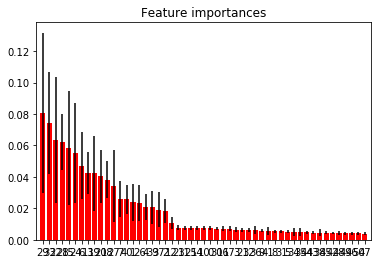

['Avg_monthly_expense_when_under_age_21'
 'Avg_monthly_expense_on_pets_or_plants' 'Avg_environmental_importance'
 'Married' 'Avg_size_per_room' 'Avg_Residancy_Altitude'
 'Avg_education_importance' 'Avg_Satisfaction_with_previous_vote'
 'Avg_monthly_household_cost' 'Phone_minutes_10_years'
 'Weighted_education_rank' 'Avg_monthly_income_all_years'
 'Last_school_grades' 'Number_of_differnt_parties_voted_for'
 'Political_interest_Total_Score' 'Overall_happiness_score'
 'Most_Important_Issue_Military' 'Most_Important_Issue_Other']
{'svm': 0.894, 'forest': 0.915, 'knn': 0.865}


In [707]:
############## ExtraTree_feature_selection #################
# try extra tree feature selection with feature importance values
features = sklearn_ExtraTree_feature_selection(X_train, y_train, 18)
print(X_train.columns.values[sorted(features)])
print(test_accuracy(X_train.iloc[:,features], y_train, X_val.iloc[:,features], y_val))
features = list(X_train.columns.values[features]) 
extratree_features = features

['Avg_Residancy_Altitude', 'Avg_education_importance', 'Weighted_education_rank', 'Avg_monthly_income_all_years', 'Last_school_grades', 'Number_of_differnt_parties_voted_for', 'Overall_happiness_score']
{'svm': 0.88, 'forest': 0.919, 'knn': 0.845, 'sgd': 0.539, 'bn': 0.785}


In [708]:
################## RFE ################
# test recursive feature elimination 
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier

num = 18
estimator = RandomForestClassifier(random_state=101)
selector = RFE(estimator, num, step=1)
selector = selector.fit(X_train, y_train)
selected_features = selector.get_support(indices=True)
print(f'Features number: {num}, features: {selected_features}')
print(test_accuracy(X_train.iloc[:,selected_features], y_train, X_val.iloc[:,selected_features], y_val))
print(X_train.columns[selected_features])
rfe_features = X_train.columns[selected_features]

Features number: 18, features: [ 1  2  4  6  7 12 13 15 18 19 20 22 24 26 27 28 29 33]
{'svm': 0.899, 'forest': 0.911, 'knn': 0.854}
Index(['Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses',
       'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
       'Married', 'Yearly_IncomeK', 'Avg_size_per_room',
       'Avg_Residancy_Altitude', 'Avg_education_importance',
       'Avg_Satisfaction_with_previous_vote', 'Avg_monthly_household_cost',
       'Phone_minutes_10_years', 'Weighted_education_rank',
       'Avg_monthly_income_all_years', 'Last_school_grades',
       'Number_of_differnt_parties_voted_for',
       'Political_interest_Total_Score', 'Overall_happiness_score'],
      dtype='object')


In [345]:
Features number: 8, features: [ 6 13 22 24 27 28 29 33]
{'svm': 0.871, 'forest': 0.889, 'knn': 0.871, 'sgd': 0.697, 'bn': 0.742}
Features number: 9, features: [ 6 13 15 22 24 27 28 29 33]
{'svm': 0.874, 'forest': 0.893, 'knn': 0.869, 'sgd': 0.693, 'bn': 0.745}
Features number: 10, features: [ 6 13 15 18 22 24 27 28 29 33]
{'svm': 0.881, 'forest': 0.891, 'knn': 0.868, 'sgd': 0.698, 'bn': 0.731}
Features number: 11, features: [ 6 13 15 18 20 22 24 27 28 29 33]
{'svm': 0.881, 'forest': 0.893, 'knn': 0.872, 'sgd': 0.697, 'bn': 0.718}
Features number: 12, features: [ 6 13 15 18 19 20 22 24 27 28 29 33]
{'svm': 0.887, 'forest': 0.898, 'knn': 0.858, 'sgd': 0.696, 'bn': 0.729}
Features number: 13, features: [ 6 13 15 18 19 20 22 24 26 27 28 29 33]
{'svm': 0.906, 'forest': 0.921, 'knn': 0.851, 'sgd': 0.749, 'bn': 0.77}
Features number: 14, features: [ 4  6 13 15 18 19 20 22 24 26 27 28 29 33]
{'svm': 0.903, 'forest': 0.918, 'knn': 0.849, 'sgd': 0.755, 'bn': 0.773}
Features number: 15, features: [ 4  6  7 13 15 18 19 20 22 24 26 27 28 29 33]
{'svm': 0.899, 'forest': 0.931, 'knn': 0.859, 'sgd': 0.763, 'bn': 0.767}
Features number: 16, features: [ 1  4  6  7 13 15 18 19 20 22 24 26 27 28 29 33]
{'svm': 0.895, 'forest': 0.926, 'knn': 0.859, 'sgd': 0.787, 'bn': 0.763}
Features number: 17, features: [ 1  4  6  7 13 15 18 19 20 22 24 26 27 28 29 33 40]
{'svm': 0.895, 'forest': 0.929, 'knn': 0.862, 'sgd': 0.799, 'bn': 0.743}

['Avg_monthly_expense_on_pets_or_plants' 'Avg_environmental_importance'
 'Married' 'Avg_size_per_room' 'Avg_Residancy_Altitude'
 'Avg_education_importance' 'Avg_Satisfaction_with_previous_vote'
 'Avg_monthly_household_cost' 'Phone_minutes_10_years'
 'Weighted_education_rank' 'Avg_monthly_income_all_years'
 'Last_school_grades' 'Number_of_differnt_parties_voted_for'
 'Political_interest_Total_Score' 'Overall_happiness_score']


Converged = True
means = [[0.4638250810125124, -12.149704063562247], [-0.7304866168211112, -12.433534312498123], [-12.568579122089258, 4.859784235446507], [15.401341955664625, 17.968566507782068], [-3.9202783372803798, -0.16528676708338372]]
covs = [[[0.19050009988666675, 0.01992149290133264], [0.01992149290133264, 0.8425575044339427]], [[0.9535423523078218, 0.9779649592882643], [0.9779649592882641, 1.657519314829415]], [[0.946331786314754, 0.6927480907290884], [0.6927480907290884, 1.3810659372869527]], [[20.775323296770274, -2.1164306649767317], [-2.1164306649767317, 1.660002069161688]], [[0.950040325816826, 0.7200788636133403], [0.7200788636133403, 1.3718125181876333]]]
prediction: 
[[0.00000000e+000 4.76917923e-149 1.10430917e-125 1.00000000e+000
  5.81579048e-062]
 [6.10319223e-276 0.00000000e+000 1.00000000e+000 7.80933039e-042
  1.81296640e-055]
 [0.00000000e+000 1.02434188e-168 1.54792587e-127 1.00000000e+000
  1.28514570e-070]]


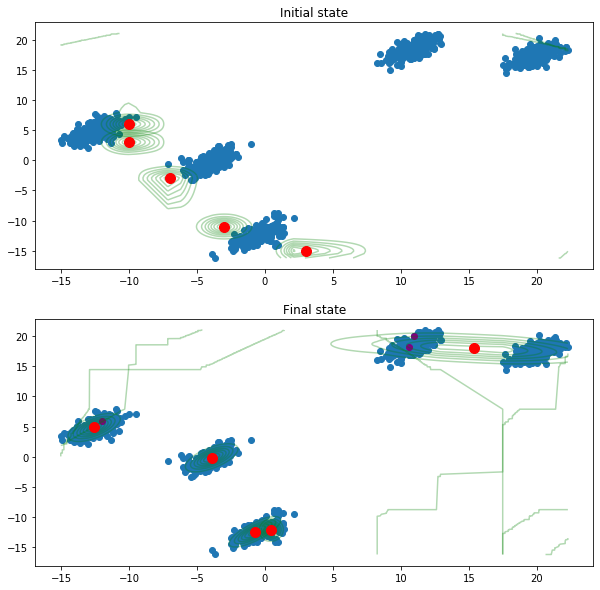

In [442]:
##### EM PART ####

from EM import *
from sklearn.mixture import GaussianMixture

from sklearn.datasets import make_blobs

# 0. Create dataset
X,Y = make_blobs(cluster_std=0.5,random_state=20,n_samples=1000,centers=2)

# Stratch dataset to get ellipsoid data
X = np.dot(X,np.random.RandomState(0).randn(2,2))

x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
XY = np.array([x.flatten(),y.flatten()]).T

fig, (ax0,ax1) = plt.subplots(2,figsize=(10, 10))

ax0.scatter(X[:, 0], X[:, 1])
ax0.set_title('Initial state')
EM = EM(n_components=2, max_iter=100)
res = EM.fit(X)
print(f'means = {EM.means_()}')
print(f'covs = {EM.covs_()}')
for c in res[0].values():
    multi_normal = multivariate_normal(mean=c['mean'],cov=c['cov'])
    ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='green',alpha=0.3)
    ax0.scatter(c['mean'][0],c['mean'][1],c='red',zorder=10,s=100)



ax1.scatter(X[:, 0], X[:, 1])
ax1.scatter(X[:3,0], X[:3,1], c='purple')

ax1.set_title('Final state')
for c in res[-1].values():
    multi_normal = multivariate_normal(mean=c['mean'],cov=c['cov'])
    ax1.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='green',alpha=0.3)
    ax1.scatter(c['mean'][0],c['mean'][1],c='red',zorder=10,s=100)
    
print(f'prediction: \n{EM.predict(X[:3])}')

In [ ]:
GMM = GaussianMixture(n_components=3).fit(X) # Instantiate and fit the model
print('Converged:',GMM.converged_) # Check if the model has converged
means = GMM.means_ 
covariances = GMM.covariances_

print(f'means = {means}\n cov = {covariances}')

# Predict
Y = np.array([[0.5],[0.5]])
prediction = GMM.predict_proba(Y.T)
print(GMM.get_params())

# Plot   
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1])
ax0.scatter(Y[0,:],Y[1,:],c='orange',zorder=10,s=100)
for m,c in zip(means,covariances):
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    
plt.show()

In [545]:
select14 = set(['Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
 'Avg_size_per_room' ,'Avg_Residancy_Altitude', 'Avg_education_importance',
 'Avg_Satisfaction_with_previous_vote' ,'Avg_monthly_household_cost',
 'Phone_minutes_10_years' ,'Weighted_education_rank',
 'Avg_monthly_income_all_years', 'Last_school_grades',
 'Number_of_differnt_parties_voted_for' ,'Political_interest_Total_Score',
 'Overall_happiness_score'])
extratree19 = set(['Avg_monthly_expense_when_under_age_21',
 'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
 'Married', 'Avg_size_per_room', 'Avg_Residancy_Altitude',
 'Avg_education_importance' ,'Avg_Satisfaction_with_previous_vote',
 'Avg_monthly_household_cost' ,'Phone_minutes_10_years',
 'Weighted_education_rank' ,'Avg_monthly_income_all_years',
 'Last_school_grades', 'Number_of_differnt_parties_voted_for',
 'Political_interest_Total_Score', 'Overall_happiness_score',
 'Foreign_Affairs', 'Military' ,'Other'])
sfsforest = set(['Avg_monthly_expense_when_under_age_21',
 'Avg_environmental_importance',
 'Avg_size_per_room',
 'Phone_minutes_10_years',
 'Last_school_grades',
 'Number_of_differnt_parties_voted_for',
 'Political_interest_Total_Score',
 'Overall_happiness_score',
 'Foreign_Affairs',
 'Military'])

sfsforest2 = set(['Avg_monthly_expense_when_under_age_21',
'Avg_size_per_room', 'Weighted_education_rank',
'Last_school_grades', 'Number_of_differnt_parties_voted_for',
'Overall_happiness_score'])

rfe15 = set(['Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
 'Married', 'Avg_size_per_room', 'Avg_Residancy_Altitude',
 'Avg_education_importance', 'Avg_Satisfaction_with_previous_vote',
 'Avg_monthly_household_cost', 'Phone_minutes_10_years',
 'Weighted_education_rank' ,'Avg_monthly_income_all_years',
 'Last_school_grades' ,'Number_of_differnt_parties_voted_for',
 'Political_interest_Total_Score' ,'Overall_happiness_score'])

select142 = set(['Avg_monthly_expense_when_under_age_21',
 'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
 'Avg_size_per_room', 'Avg_Residancy_Altitude' ,'Avg_education_importance',
 'Avg_Satisfaction_with_previous_vote' ,'Avg_monthly_household_cost',
 'Phone_minutes_10_years', 'Weighted_education_rank' ,'Last_school_grades',
 'Number_of_differnt_parties_voted_for', 'Political_interest_Total_Score',
 'Overall_happiness_score'])

extratree15 = set(['Avg_environmental_importance', 'Married', 'Avg_size_per_room',
 'Avg_Residancy_Altitude', 'Avg_education_importance',
 'Avg_Satisfaction_with_previous_vote', 'Avg_monthly_household_cost',
 'Phone_minutes_10_years', 'Weighted_education_rank',
 'Avg_monthly_income_all_years' ,'Last_school_grades',
 'Number_of_differnt_parties_voted_for', 'Political_interest_Total_Score',
 'Overall_happiness_score', 'Most_Important_Issue_Other'])

select143 = set(['Avg_monthly_expense_when_under_age_21',
 'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
 'Avg_size_per_room' ,'Avg_Residancy_Altitude' ,'Avg_education_importance',
 'Avg_Satisfaction_with_previous_vote', 'Avg_monthly_household_cost',
 'Phone_minutes_10_years', 'Weighted_education_rank' 'Last_school_grades',
 'Number_of_differnt_parties_voted_for', 'Political_interest_Total_Score',
 'Overall_happiness_score'])

rfe17 = set(['Avg_monthly_expense_when_under_age_21', 'Avg_lottary_expanses',
       'Avg_monthly_expense_on_pets_or_plants', 'Avg_environmental_importance',
       'Yearly_IncomeK', 'Avg_size_per_room', 'Avg_Residancy_Altitude',
       'Avg_education_importance', 'Avg_Satisfaction_with_previous_vote',
       'Avg_monthly_household_cost', 'Phone_minutes_10_years',
       'Weighted_education_rank', 'Avg_monthly_income_all_years',
       'Last_school_grades', 'Number_of_differnt_parties_voted_for',
       'Political_interest_Total_Score', 'Overall_happiness_score'])



{'Avg_Residancy_Altitude',
 'Avg_Satisfaction_with_previous_vote',
 'Avg_education_importance',
 'Avg_environmental_importance',
 'Avg_monthly_household_cost',
 'Avg_size_per_room',
 'Number_of_differnt_parties_voted_for',
 'Overall_happiness_score',
 'Phone_minutes_10_years',
 'Political_interest_Total_Score'}

In [711]:
sfs_knn_features = set(sfs_knn_features)
sfs_forest_features = set(sfs_forest_features)
rfe_features = set(rfe_features)
extratree_features = set(extratree_features)
selectkbest_features = set(selectkbest_features)

intersaction = sfs_knn_features & sfs_forest_features & rfe_features & extratree_features & selectkbest_features
union = sfs_knn_features | sfs_forest_features | rfe_features | extratree_features | selectkbest_features
print(f' union = {union}') # 22
print(f' intersaction = {intersaction}') # 8
len(union - intersaction)

 union = {'Yearly_IncomeK', 'Avg_Satisfaction_with_previous_vote', 'Number_of_differnt_parties_voted_for', 'Avg_monthly_expense_when_under_age_21', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_size_per_room', 'Most_Important_Issue_Other', 'Num_of_kids_born_last_10_years', 'Last_school_grades', 'Most_Important_Issue_Foreign_Affairs', 'Avg_lottary_expanses', 'Avg_monthly_household_cost', 'Avg_environmental_importance', 'Married', 'Political_interest_Total_Score', 'Overall_happiness_score', 'Avg_monthly_income_all_years', 'Avg_education_importance', 'Avg_Residancy_Altitude', 'Weighted_education_rank', 'Phone_minutes_10_years', 'Most_Important_Issue_Military'}
 intersaction = {'Last_school_grades', 'Avg_Residancy_Altitude', 'Avg_size_per_room', 'Number_of_differnt_parties_voted_for', 'Avg_monthly_household_cost', 'Phone_minutes_10_years', 'Avg_environmental_importance', 'Overall_happiness_score'}


14

In [602]:
for num in range(7,22):
    estimator = RandomForestClassifier(random_state=101)
    selector = RFE(estimator, num, step=1)
    selector = selector.fit(X_train[union], y_train)
    selected_features = selector.get_support(indices=True)
    print(f'Features number: {num}, features: {selected_features}')
    print(test_accuracy(X_train[union].iloc[:,selected_features], y_train, X_val[union].iloc[:,selected_features], y_val))
    #print(X_train.columns[selected_features])

Features number: 7, features: [ 9 13 15 16 18 19 20]
{'svm': 0.819, 'forest': 0.861, 'knn': 0.837, 'sgd': 0.595, 'bn': 0.686}
Features number: 8, features: [ 9 13 15 16 17 18 19 20]
{'svm': 0.83, 'forest': 0.9, 'knn': 0.823, 'sgd': 0.63, 'bn': 0.738}
Features number: 9, features: [ 1  9 13 15 16 17 18 19 20]
{'svm': 0.819, 'forest': 0.892, 'knn': 0.817, 'sgd': 0.653, 'bn': 0.747}
Features number: 10, features: [ 1  9 13 15 16 17 18 19 20 21]
{'svm': 0.831, 'forest': 0.879, 'knn': 0.817, 'sgd': 0.65, 'bn': 0.747}
Features number: 11, features: [ 1  6  9 13 15 16 17 18 19 20 21]
{'svm': 0.834, 'forest': 0.896, 'knn': 0.825, 'sgd': 0.655, 'bn': 0.739}
Features number: 12, features: [ 1  3  6  9 13 15 16 17 18 19 20 21]
{'svm': 0.891, 'forest': 0.916, 'knn': 0.862, 'sgd': 0.739, 'bn': 0.778}
Features number: 13, features: [ 1  3  6  9 12 13 15 16 17 18 19 20 21]
{'svm': 0.89, 'forest': 0.912, 'knn': 0.861, 'sgd': 0.733, 'bn': 0.763}
Features number: 14, features: [ 1  3  5  6  9 12 13 15 1

In [610]:

features = ['Most_Important_Issue_Other' ,'Most_Important_Issue_Foreign_Affairs',
 'Most_Important_Issue_Military','Avg_Satisfaction_with_previous_vote',
 'Number_of_differnt_parties_voted_for',
 'Avg_monthly_expense_on_pets_or_plants', 'Avg_size_per_room',
 'Last_school_grades' ,'Avg_monthly_household_cost',
 'Avg_environmental_importance', 'Political_interest_Total_Score',
 'Overall_happiness_score' ,'Avg_education_importance',
 'Avg_Residancy_Altitude', 'Weighted_education_rank',
 'Phone_minutes_10_years','Avg_monthly_expense_when_under_age_21']
    
print(test_accuracy(X_train[features], y_train, X_val[features], y_val))

{'svm': 0.891, 'forest': 0.917, 'knn': 0.859, 'sgd': 0.795, 'bn': 0.787}


In [ ]:
union - {'svm': 0.89, 'forest': 0.903, 'knn': 0.839, 'sgd': 0.805, 'bn': 0.777}
inter - {'svm': 0.873, 'forest': 0.885, 'knn': 0.861, 'sgd': 0.443, 'bn': 0.727}
14 rfe - {'svm': 0.891, 'forest': 0.921, 'knn': 0.85, 'sgd': 0.755, 'bn': 0.771} [ 1  3  5  6  9 12 13 15 16 17 18 19 20 21] (from union)
17 rfe - {'svm': 0.881, 'forest': 0.917, 'knn': 0.847, 'sgd': 0.777, 'bn': 0.757} [ 1  3  4  5  6  9 11 12 13 14 15 16 17 18 19 20 21] (from union)
relief 15 -{'svm': 0.863, 'forest': 0.895, 'knn': 0.85, 'sgd': 0.744, 'bn': 0.791} ['Most_Important_Issue_Other' 'Most_Important_Issue_Foreign_Affairs'
 'Most_Important_Issue_Military' 'Avg_monthly_expense_on_pets_or_plants'
 'Overall_happiness_score' 'Avg_lottary_expanses'
 'Political_interest_Total_Score' 'Number_of_differnt_parties_voted_for'
 'Avg_education_importance' 'Avg_size_per_room' 'Weighted_education_rank'
 'Avg_monthly_income_all_years' 'Avg_Residancy_Altitude'
 'Avg_monthly_expense_when_under_age_21']
select13best 13 {'svm': 0.889, 'forest': 0.927, 'knn': 0.855, 'sgd': 0.749, 'bn': 0.766}
['Avg_Satisfaction_with_previous_vote'
 'Number_of_differnt_parties_voted_for'
 'Avg_monthly_expense_on_pets_or_plants' 'Avg_size_per_room'
 'Last_school_grades' 'Avg_monthly_household_cost'
 'Avg_environmental_importance' 'Political_interest_Total_Score'
 'Overall_happiness_score' 'Avg_education_importance'
 'Avg_Residancy_Altitude' 'Weighted_education_rank'
 'Phone_minutes_10_years']


In [ ]:
#union = {'Yearly_IncomeK', 'Avg_Satisfaction_with_previous_vote', 'Avg_government_satisfaction', 'Number_of_differnt_parties_voted_for', 'Avg_monthly_expense_when_under_age_21', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_size_per_room', 'Most_Important_Issue_Other', 'Occupation_Services_or_Retail', 'Last_school_grades', 'Most_Important_Issue_Foreign_Affairs', 'Avg_lottary_expanses', 'Avg_monthly_household_cost', 'Avg_environmental_importance', 'Married', 'Political_interest_Total_Score', 'Overall_happiness_score', 'Avg_monthly_income_all_years', 'Avg_education_importance', 'Avg_Residancy_Altitude', 'Weighted_education_rank', 'Phone_minutes_10_years', 'Most_Important_Issue_Military'}
#intersaction = {'Last_school_grades', 'Avg_Residancy_Altitude', 'Weighted_education_rank', 'Avg_size_per_room', 'Number_of_differnt_parties_voted_for', 'Avg_environmental_importance', 'Overall_happiness_score'}


In [ ]:
import itertools
base = intersaction
best_svm = 0
svm_feat = None
best_knn = 0
knn_feat = None
best_forest = 0 
forest_feat = None
best_sum = 0
sum_feat = None
i = 0
for n in range(4,12):
    for subset in list(itertools.combinations(union - base, n)):
        i += 1
        features = base | set(subset) 
        accuracy = test_accuracy(X_train[features], y_train, X_val[features], y_val)
        if best_svm < accuracy['svm']:
            best_svm = accuracy['svm']
            svm_feat = features
        if best_knn < accuracy['knn']:
            best_knn = accuracy['knn']
            knn_feat = features     
        if best_forest < accuracy['forest']:
            best_forest = accuracy['forest']
            forest_feat = features
        acc_sum = accuracy['svm'] + accuracy['knn'] + accuracy['forest']
        if best_sum < acc_sum:
            best_sum = acc_sum
            sum_feat = features
        print('Iteration  %d   svm = %06f   forest = %06f   knn = %06f' % 
                (i, best_svm, best_forest, best_knn), '\r', end='')
print(f'Best svm = {best_svm}\n {svm_feat}')
print(f'Best knn = {best_knn}\n {knn_feat}')
print(f'Best forest = {best_forest}\n {forest_feat}')
print(f'Best sum = {best_sum}\n {sum_feat}')

In [621]:
print(f'Best svm = {best_svm}\n {svm_feat}')
print(f'Best knn = {best_knn}\n {knn_feat}')
print(f'Best forest = {best_forest}\n {forest_feat}')
print(f'Best sum = {best_sum}\n {sum_feat}')

Best svm = 0.909
 {'Avg_monthly_income_all_years', 'Yearly_IncomeK', 'Last_school_grades', 'Avg_education_importance', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vote', 'Weighted_education_rank', 'Avg_size_per_room', 'Most_Important_Issue_Foreign_Affairs', 'Number_of_differnt_parties_voted_for', 'Phone_minutes_10_years', 'Avg_environmental_importance', 'Political_interest_Total_Score', 'Overall_happiness_score'}
Best knn = 0.872
 {'Last_school_grades', 'Avg_education_importance', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_Residancy_Altitude', 'Weighted_education_rank', 'Avg_size_per_room', 'Number_of_differnt_parties_voted_for', 'Avg_monthly_household_cost', 'Most_Important_Issue_Other', 'Avg_environmental_importance', 'Political_interest_Total_Score', 'Overall_happiness_score'}
Best forest = 0.929
 {'Yearly_IncomeK', 'Last_school_grades', 'Avg_education_importance', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vot

In [ ]:
23950 iterations
Best svm = 0.909
 {'Avg_monthly_income_all_years', 'Yearly_IncomeK', 'Last_school_grades', 'Avg_education_importance', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vote', 'Weighted_education_rank', 'Avg_size_per_room', 'Most_Important_Issue_Foreign_Affairs', 'Number_of_differnt_parties_voted_for', 'Phone_minutes_10_years', 'Avg_environmental_importance', 'Political_interest_Total_Score', 'Overall_happiness_score'}
Best knn = 0.872
 {'Last_school_grades', 'Avg_education_importance', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_Residancy_Altitude', 'Weighted_education_rank', 'Avg_size_per_room', 'Number_of_differnt_parties_voted_for', 'Avg_monthly_household_cost', 'Most_Important_Issue_Other', 'Avg_environmental_importance', 'Political_interest_Total_Score', 'Overall_happiness_score'}
Best forest = 0.929
 {'Yearly_IncomeK', 'Last_school_grades', 'Avg_education_importance', 'Avg_monthly_expense_on_pets_or_plants', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vote', 'Weighted_education_rank', 'Avg_size_per_room', 'Most_Important_Issue_Foreign_Affairs', 'Number_of_differnt_parties_voted_for', 'Occupation_Services_or_Retail', 'Avg_environmental_importance', 'Married', 'Overall_happiness_score'}
Best sum = 2.697
 {'Avg_monthly_income_all_years', 'Yearly_IncomeK', 'Last_school_grades', 'Avg_education_importance', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vote', 'Weighted_education_rank', 'Avg_size_per_room', 'Most_Important_Issue_Foreign_Affairs', 'Number_of_differnt_parties_voted_for', 'Phone_minutes_10_years', 'Avg_environmental_importance', 'Political_interest_Total_Score', 'Overall_happiness_score'}

In [623]:
features = ['Avg_monthly_income_all_years', 'Yearly_IncomeK', 'Last_school_grades', 'Avg_education_importance', 'Avg_Residancy_Altitude', 'Avg_Satisfaction_with_previous_vote', 'Weighted_education_rank', 'Avg_size_per_room', 'Most_Important_Issue_Foreign_Affairs', 'Number_of_differnt_parties_voted_for', 'Phone_minutes_10_years', 'Avg_environmental_importance', 'Political_interest_Total_Score', 'Overall_happiness_score']
print( test_accuracy(X_train[features], y_train, X_val[features], y_val))

{'svm': 0.909, 'forest': 0.921, 'knn': 0.867, 'sgd': 0.867, 'bn': 0.867}
{'Avg_monthly_income_all_years', 'Yearly_IncomeK', 'Avg_education_importance', 'Avg_Satisfaction_with_previous_vote', 'Most_Important_Issue_Foreign_Affairs', 'Phone_minutes_10_years', 'Political_interest_Total_Score'}
